In [1]:
import pynucastro as pyna
from pynucastro.screening import chugunov_2009

In [2]:
rl = pyna.ReacLibLibrary()

nucs = ["p", "he4",
        "c12", "o16", "ne20",
        "mg24", "si28", "s32",
        "ar36", "ca40", "ti44",
        "cr48", "fe52", "ni56",
        "al27", "p31", "cl35",
        "k39", "sc43", "v47",
        "mn51", "co55",
        "n13", "n14", "f18",
        "ne21", "na22", "na23"]

subch = rl.linking_nuclei(nucs)

other = [(("c12", "c12"), ("mg23", "n"), ("mg24")),
         (("o16", "o16"), ("s31", "n"), ("s32")),
         (("c12", "o16"), ("si27", "n"), ("si28"))]

for r, p, mp in other:
    rfilter = pyna.RateFilter(reactants=r,
                              products=p)
    _library = rl.filter(rfilter)
    r = _library.get_rates()[0]
    r.modify_products(mp)
    subch += _library

rc = pyna.PythonNetwork(libraries=[subch], symmetric_screening=True)

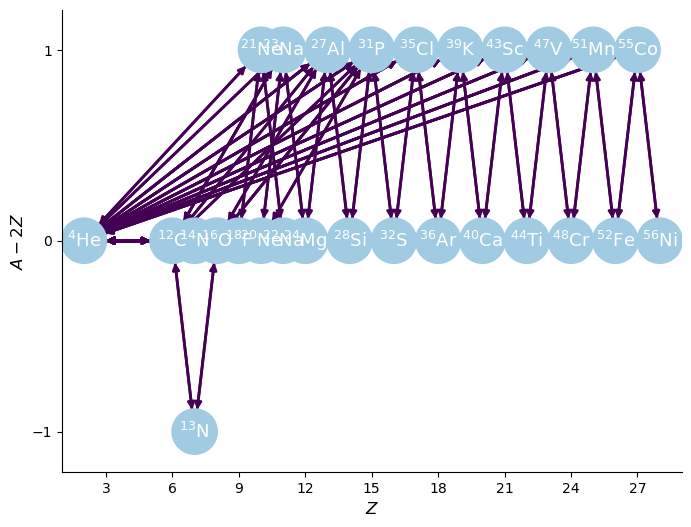

In [3]:
rc.plot(rotated=True)

In [4]:
rc.write_network("subch.py")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import subch

In [6]:
rho = 1.e6
T = 2.e9

X0 = np.zeros(subch.nnuc)
X0[subch.jhe4] = 0.99
X0[subch.jn14] = 0.01

Y0 = X0/subch.A

In [7]:
ydot = subch.rhs(0, Y0, rho, T, chugunov_2009)
print(ydot)

[ 0.00000000e+00 -3.35051007e+03  1.00643238e+00  0.00000000e+00
 -3.34749078e+03  0.00000000e+00  3.34749078e+03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]


In [8]:
tmax = 1.e-3

sol = solve_ivp(subch.rhs, [0, tmax], Y0, method="BDF", jac=subch.jacobian,
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-8)

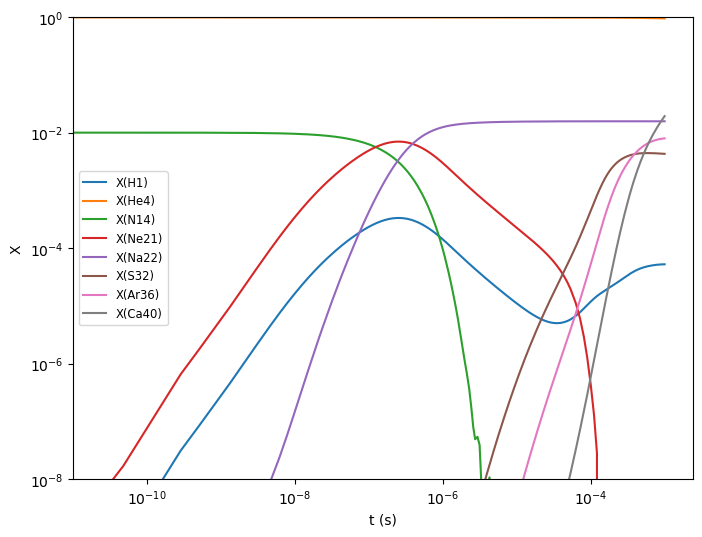

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

threshold = 1.e-4

for i in range(subch.nnuc):
    if (sol.y[i,:]).max() > threshold:
        ax.loglog(sol.t, sol.y[i,:] * subch.A[i], label=f"X({subch.names[i].capitalize()})")

ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")
ax.set_xlabel("t (s)")
ax.set_ylabel("X")

fig.set_size_inches((8, 6))

In [10]:
len(sol.t)

144

In [11]:
sum = 0.0
for n in range(subch.nnuc):
    print(subch.names[n], sol.y[n,-1]*subch.A[n])
    sum += sol.y[n,-1]*subch.A[n]

h1 5.247049831184964e-05
he4 0.9493813310949776
c12 8.992165947309784e-05
n13 4.823426949452835e-09
n14 6.168490225026511e-24
o16 0.00013527385289653185
f18 1.6361223169768202e-18
ne20 3.619846685236713e-05
ne21 8.844533885458924e-11
na22 0.015714285621628687
na23 2.32240233408582e-07
mg24 6.60644027733818e-05
al27 4.6421225037382624e-05
si28 0.0006547079239079895
p31 2.8362965061784718e-05
s32 0.0042917367149050345
cl35 0.00028920901636654426
ar36 0.007952865102112678
k39 0.001616625123008205
ca40 0.019298509600750316
sc43 3.747969449191782e-06
ti44 0.0003390716989356007
v47 1.142124387805071e-06
cr48 1.816175220549166e-06
mn51 1.283149972876538e-09
fe52 3.2865917399244317e-10
co55 2.7204886121786143e-14
ni56 1.3509809834995636e-15


In [18]:
sum

1.0000000000000002

In [12]:
def rhs_wrap(t, X, rho, T, screening_func):
    # compute Y
    Y = X / subch.A
    ydot = subch.rhs(t, Y, rho, T, screening_func)
    xdot = subch.A * ydot
    return xdot

In [13]:
sol = solve_ivp(rhs_wrap, [0, tmax], X0, method="BDF",
                dense_output=True, args=(rho, T, chugunov_2009), rtol=1.e-6, atol=1.e-8)

In [14]:
for n in range(subch.nnuc):
    print(subch.names[n], sol.y[n,-1])

h1 5.247037916250272e-05
he4 0.949381317018213
c12 8.99214076274008e-05
n13 4.823432946504872e-09
n14 6.1687164668118425e-24
o16 0.00013527462136933555
f18 1.636174948780817e-18
ne20 3.619870708180624e-05
ne21 8.844925899841525e-11
na22 0.015714285621640345
na23 2.3224065993618216e-07
mg24 6.606487173850579e-05
al27 4.6421382637304655e-05
si28 0.0006547134186716554
p31 2.836288627961021e-05
s32 0.004291672195598096
cl35 0.00028920373069988035
ar36 0.00795287183165047
k39 0.0016166262137914534
ca40 0.019298581251746067
sc43 3.747994410255408e-06
ti44 0.00033906934392699127
v47 1.1421231530350736e-06
cr48 1.8162367568022736e-06
mn51 1.2830306631119946e-09
fe52 3.2821331300696366e-10
co55 2.7086635614186857e-14
ni56 1.3363631663212467e-15
